In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import plotly.graph_objects as go
from torchvision import transforms, utils
from IPython.display import display
from glob import glob

### RL and Advanced DL: Домашнее задание 3

Третье домашнее задание посвящено порождающим моделям, а точнее — порождающим состязательным сетям. Это самое маленькое и самое техническое задание в курсе, но что уж поделать. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

#### Часть первая: перенос стиля при помощи pix2pix

В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов.


Датасет можно скачать здесь (и во многих других местах, должно быть ~29 мегабайт).
В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля (подробнее см. лекцию и собственно Isola et al., 2016)

Архитектуру подсмотрел тут: Архитектуру

In [ ]:
def encoder_layer(in_channel, out_channel):
    layer = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channel, affine=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),        
    )    
    return layer

def decoder_layer(in_channel, out_channel, dropout=True):
     
    layer = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channel, affine=True),
            nn.Dropout2d(p=0.5, inplace=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),         
    )

    return layer

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_image=3, filter_size=64):
        super().__init__()
        self.enc = nn.MaxPool2d(kernel_size=2)
        self.dec = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.enc1 = encoder_layer(in_image, filter_size)
        self.enc2 = encoder_layer(filter_size, filter_size * 2)
        self.enc3 = encoder_layer(filter_size * 2, filter_size * 4)
        self.enc4 = encoder_layer(filter_size * 4, filter_size * 8)
        self.enc5 = encoder_layer(filter_size * 8, filter_size * 8)
        self.enc6 = encoder_layer(filter_size * 8, filter_size * 8)
        
        self.dec1 = decoder_layer(filter_size * 8 + filter_size * 8, filter_size * 8)
        self.dec2 = decoder_layer(filter_size * 8  + filter_size * 8, filter_size * 8)
        self.dec3 = decoder_layer(filter_size * 4 + filter_size * 8, filter_size * 4)
        self.dec4 = decoder_layer(filter_size * 4 + filter_size * 2, filter_size * 2)
        self.dec5 = decoder_layer(filter_size * 2 + filter_size, filter_size)
        self.dec6 = nn.Conv2d(64, 3, kernel_size=1)
        
        
    def forward(self, x):
        out1 = self.enc1(x)
        out2 = self.enc2(self.enc(out1))
        out3 = self.enc3(self.enc(out2))
        out4 = self.enc4(self.enc(out3))
        out5 = self.enc5(self.enc(out4))
        out_enc = self.enc6(self.enc(out5))
        dec_1 = self.dec1(torch.cat([self.dec(out_enc), out5], dim=1))
        dec_2 = self.dec2(torch.cat([self.dec(dec_1), out4], dim=1))
        dec_3 = self.dec3(torch.cat([self.dec(dec_2), out3], dim=1))
        dec_4 = self.dec4(torch.cat([self.dec(dec_3), out2], dim=1))
        dec_5 = self.dec5(torch.cat([self.dec(dec_4), out1], dim=1))
        return torch.sigmoid(self.dec6(dec_5))
    
    
class Discriminator(nn.Module):
    def __init__(self, in_image=6, filter_size=64):
        super().__init__()
        self.enc = nn.MaxPool2d(kernel_size=2)
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.enc1 = encoder_layer(in_image, filter_size)
        self.enc2 = encoder_layer(filter_size, filter_size * 2)
        self.enc3 = encoder_layer(filter_size * 2, filter_size * 4)
        self.enc4 = encoder_layer(filter_size * 4, filter_size * 8)        
        self.linear = nn.Linear(filter_size * 8, 2)
        
    def forward(self, x1, x2):
        out1 = self.enc1(torch.cat([x1, x2], dim=1))
        out2 = self.enc2(self.enc(out1))
        out3 = self.enc3(self.enc(out2))
        out4 = self.enc4(self.enc(out3))
        x = self.pooling(self.enc(out4)).squeeze(-1).squeeze(-1)
        
        return self.linear(x)
        

In [ ]:
class Facades_df(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image = glob(self.root_dir + '/*.jpg')
            
    def __getitem__(self, idx):
        img = Image.open(self.image[idx]).convert("RGB")
        return transforms.ToTensor()(img.crop((256, 0, 512, 256))), transforms.ToTensor()(img.crop((0, 0, 256, 256)))
    def __len__(self):
        return len(self.image)
        

In [ ]:
from tqdm.notebook import tqdm

N_EPOCH = 50
LR = 0.0001
BETA = (0.3, 0.999)
STEP = 500
L1_LAMBDA = 100
generator = Generator().cuda()
gen_optim = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
gen_scheduler = torch.optim.lr_scheduler.StepLR(gen_optim, STEP)
discriminator = Discriminator().cuda()
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)
disc_scheduler = torch.optim.lr_scheduler.StepLR(disc_optim, STEP)

train_dataset = Facades_df(root_dir='train')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = Facades_df(root_dir='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

gen_history = list()
disc_history = list()

for i in tqdm(range(N_EPOCH)):
    for batch in train_dataloader:       
        batch[0] = batch[0].cuda()
        batch[1] = batch[1].cuda()
        
        generator.eval()
        discriminator.train()
        new_image = generator(batch[0])
        preds = discriminator(batch[0], new_image)
        real = discriminator(batch[0], batch[1])
        
        disc_optim.zero_grad()
        preds_loss = F.cross_entropy(preds, torch.zeros(preds.shape[0]).long().cuda())
        real_loss = F.cross_entropy(real, torch.ones(preds.shape[0]).long().cuda())
        
        loss = 0.5 * (real_loss + preds_loss)
        loss.backward()
        disc_optim.step()
        disc_history.append(loss.item())
        
        generator.train()
        discriminator.eval()
        
        new_image = generator(batch[0])
        preds = discriminator(batch[0], new_image)        
        loss = F.cross_entropy(preds, torch.ones(preds.shape[0]).long().cuda())
        loss = loss + L1_LAMBDA * F.l1_loss(new_image, batch[1])
        gen_optim.zero_grad()
        loss.backward()
        gen_optim.step()
        gen_history.append(loss.item())
        
    gen_scheduler.step()
    disc_scheduler.step()          

  0%|          | 0/50 [00:00<?, ?it/s]

Тестовые данные

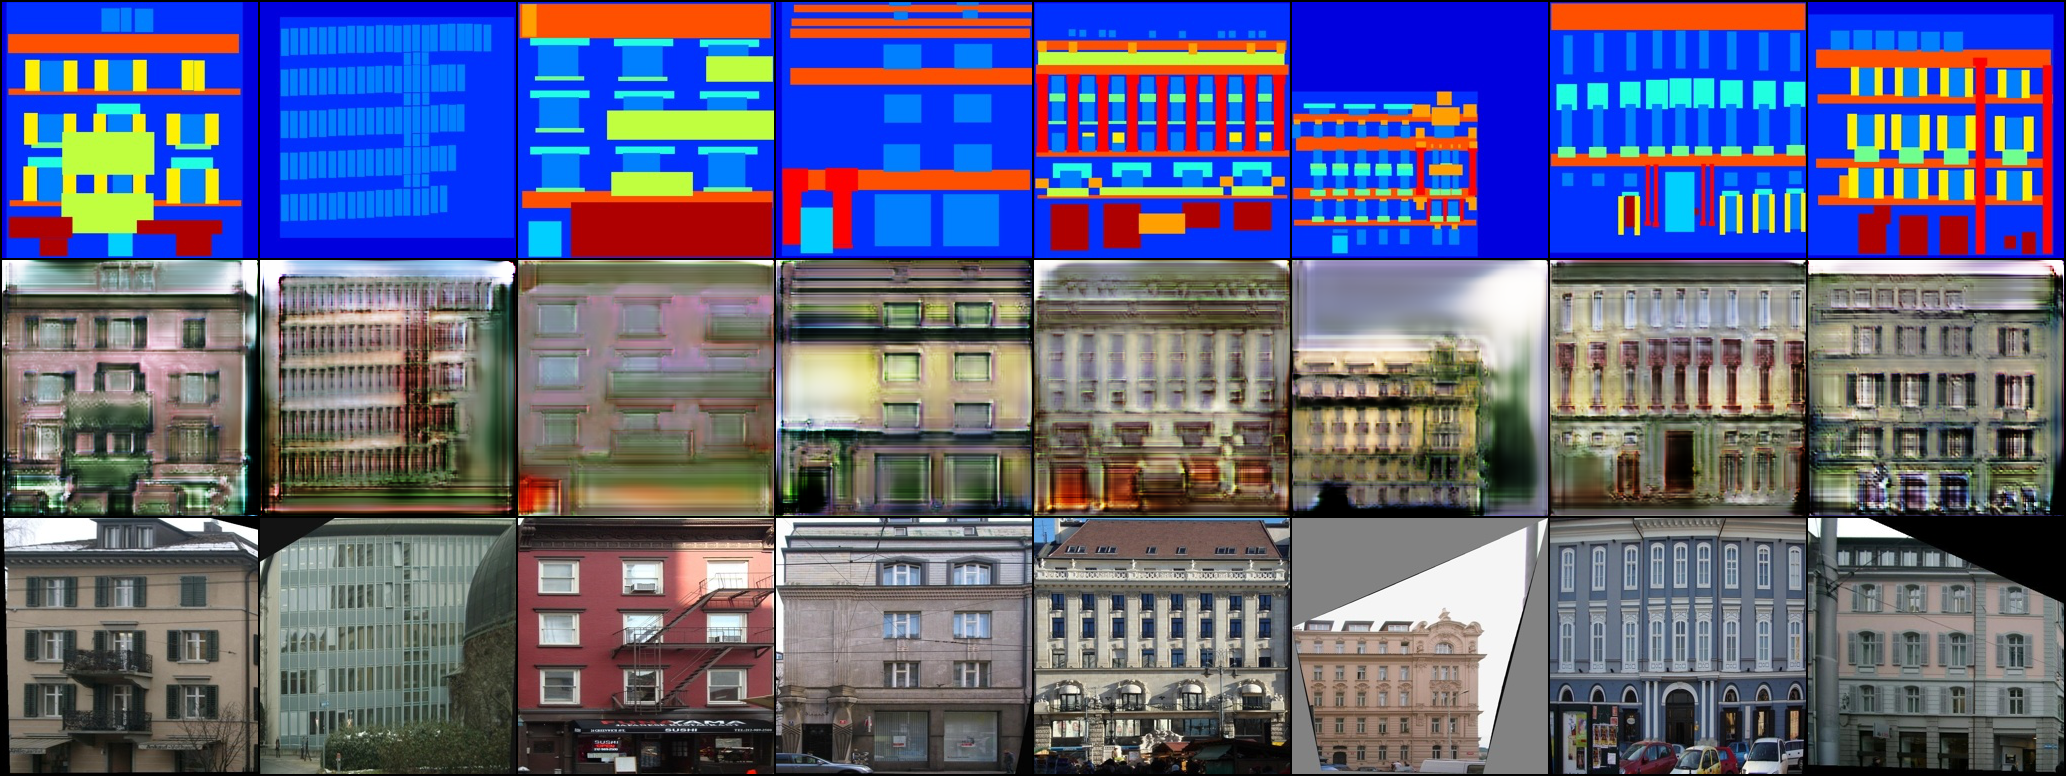

In [ ]:
for batch in test_dataloader:
    batch[0] = batch[0].cuda()
    batch[1] = batch[1].cuda()
            
    new_image = generator(batch[0]).cpu().detach()
    image = torch.cat([batch[0].cpu(), new_image, batch[1].cpu()], dim=0)
    display(transforms.ToPILImage()(utils.make_grid(image)))
    break          


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=disc_history ))

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="discriminator loss",

                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=gen_history ))

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="generator loss",

                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()